In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rc("figure", dpi=150, figsize=(6, 3))

# 13.1 Bitly Data from 1.USA.gov

In [6]:
path = "datasets/bitly_usagov/example.txt"

# json data
with open(path) as f:
    print(f.readline())

{ "a": "Mozilla\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\/535.11 (KHTML, like Gecko) Chrome\/17.0.963.78 Safari\/535.11", "c": "US", "nk": 1, "tz": "America\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\/\/www.facebook.com\/l\/7AQEFzjSi\/1.usa.gov\/wfLQtf", "u": "http:\/\/www.ncbi.nlm.nih.gov\/pubmed\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }



In [7]:
import json

# read into list of dicts
with open(path) as f:
    records = [json.loads(line) for line in f]

records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'c': 'US',
 'nk': 1,
 'tz': 'America/New_York',
 'gr': 'MA',
 'g': 'A6qOVH',
 'h': 'wfLQtf',
 'l': 'orofrog',
 'al': 'en-US,en;q=0.8',
 'hh': '1.usa.gov',
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
 't': 1331923247,
 'hc': 1331822918,
 'cy': 'Danvers',
 'll': [42.576698, -70.954903]}

## Counting Time Zones in Pure Python

In [16]:
# extract a list of time zones
time_zones = [rec["tz"] for rec in records if "tz" in rec]
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

In [14]:
# absolutely pure python
ts = {}
for rec in records:
    if "tz" not in rec:
        continue
    if rec["tz"] not in ts:
        ts[rec["tz"]] = 1
    else:
        ts[rec["tz"]] += 1

# sort
ts = [(k, v) for k, v in ts.items()]
ts.sort(key=lambda x: -x[1])
print(ts)

[('America/New_York', 1251), ('', 521), ('America/Chicago', 400), ('America/Los_Angeles', 382), ('America/Denver', 191), ('Europe/London', 74), ('Asia/Tokyo', 37), ('Pacific/Honolulu', 36), ('Europe/Madrid', 35), ('America/Sao_Paulo', 33), ('Europe/Berlin', 28), ('Europe/Rome', 27), ('America/Rainy_River', 25), ('Europe/Amsterdam', 22), ('America/Phoenix', 20), ('America/Indianapolis', 20), ('Europe/Warsaw', 16), ('America/Mexico_City', 15), ('Europe/Paris', 14), ('Europe/Stockholm', 14), ('America/Vancouver', 12), ('Pacific/Auckland', 11), ('Asia/Hong_Kong', 10), ('Europe/Prague', 10), ('Europe/Moscow', 10), ('Europe/Helsinki', 10), ('America/Puerto_Rico', 10), ('Europe/Oslo', 10), ('America/Montreal', 9), ('Asia/Calcutta', 9), ('Asia/Istanbul', 9), ('Europe/Lisbon', 8), ('Asia/Bangkok', 6), ('Europe/Vienna', 6), ('Australia/NSW', 6), ('Chile/Continental', 6), ('America/Edmonton', 6), ('Europe/Athens', 6), ('Europe/Copenhagen', 5), ('America/Anchorage', 5), ('Europe/Budapest', 5), ('A

In [17]:
# pure python for counting time zones
from collections import Counter

c = Counter(time_zones)
len(c), c["America/New_York"], len(time_zones)

(97, 1251, 3440)

In [18]:
c.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

## Counting Time Zones with pandas

In [19]:
frame = pd.DataFrame(records)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a            3440 non-null   object 
 1   c            2919 non-null   object 
 2   nk           3440 non-null   float64
 3   tz           3440 non-null   object 
 4   gr           2919 non-null   object 
 5   g            3440 non-null   object 
 6   h            3440 non-null   object 
 7   l            3440 non-null   object 
 8   al           3094 non-null   object 
 9   hh           3440 non-null   object 
 10  r            3440 non-null   object 
 11  u            3440 non-null   object 
 12  t            3440 non-null   float64
 13  hc           3440 non-null   float64
 14  cy           2919 non-null   object 
 15  ll           2919 non-null   object 
 16  _heartbeat_  120 non-null    float64
 17  kw           93 non-null     object 
dtypes: float64(4), object(14)
memory usage: 500.8+ K

In [20]:
frame["tz"].head()

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
Name: tz, dtype: object

In [21]:
# simply get the number of times each timezone occurs
tz_counts = frame["tz"].value_counts()
tz_counts.head(10)

tz
America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: count, dtype: int64

In [22]:
clean_tz = frame["tz"].fillna("Missing")    # Clean na values
clean_tz[clean_tz == ""] = "Unknown"        # get rid of empty lines ("" is not na)

tz_counts = clean_tz.value_counts()
tz_counts.head(10)  # this now includes the "Missing" category, which was left out before due to pandas' way of handling missing data

tz
America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: count, dtype: int64

<Axes: ylabel='tz'>

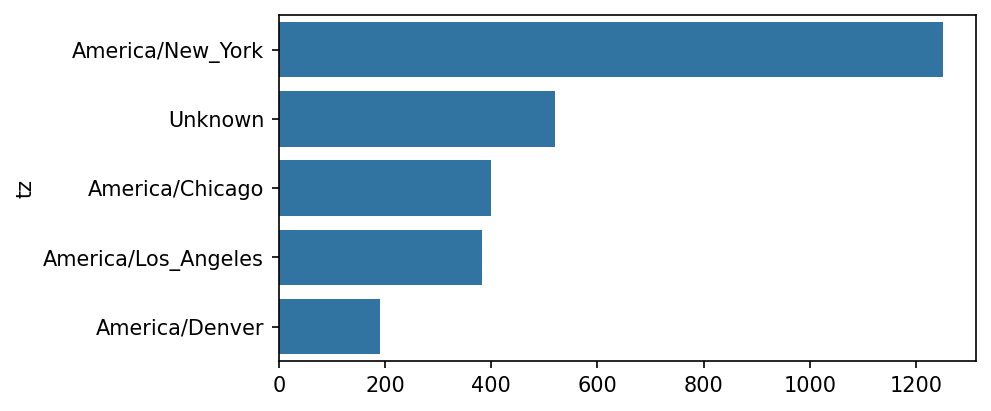

In [23]:
import seaborn as sns

subset = tz_counts.head()
sns.barplot(y=subset.index, x=subset.to_numpy())

In [24]:
# "a" field contains information about the browser, device or application used to perform the URL shortening
frame["a"][1], frame["a"][50]

('GoogleMaps/RochesterNY',
 'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2')

In [25]:
# Extract browser information
results = pd.Series([x.split()[0] for x in frame["a"].dropna()])
results.head()

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [26]:
results.value_counts().head(8)

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
Name: count, dtype: int64

In [27]:
cframe = frame[frame["a"].notna()].copy()   # get all non-null values
cframe["os"] = np.where(cframe["a"].str.contains("Windows"), "Windows", "Not Windows")  # determine whether the os is windows or not
cframe["os"].head()

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

In [28]:
by_tz_os = cframe.groupby(["tz", "os"]) # group by timezone and operating system
by_tz_os.size()

tz                 os         
                   Not Windows    245
                   Windows        276
Africa/Cairo       Windows          3
Africa/Casablanca  Windows          1
Africa/Ceuta       Windows          2
                                 ... 
Europe/Warsaw      Windows         15
Europe/Zurich      Not Windows      4
Pacific/Auckland   Not Windows      3
                   Windows          8
Pacific/Honolulu   Windows         36
Length: 149, dtype: int64

In [29]:
# size(): get the number of occurrences per category; unstack(): unstack the lowest level index and turn it into columns
# fillna(0): any missing values are filled with 0
# we now have a dataframe that tells us the number of occurrence of each time zone (index) and whether the user used Windows or not (column)
agg_counts = by_tz_os.size().unstack().fillna(0)
print(agg_counts.head())

os                   Not Windows  Windows
tz                                       
                           245.0    276.0
Africa/Cairo                 0.0      3.0
Africa/Casablanca            0.0      1.0
Africa/Ceuta                 0.0      2.0
Africa/Johannesburg          0.0      1.0


In [30]:
# - we first compute the sum per index (time zone)
# - argsort() then creates a new series, where indexer[i] = j means original position j would appear at sorted position i
# - so the values are the original position from the previous dataframe
# - and the position tells us where this value is now
# - the timezone index is useless, this does not mean tz[Africa/Cairo] used to be position 7!
indexer = agg_counts.sum("columns").argsort()

In [31]:
indexer[-10:]

tz
Europe/Sofia        35
Europe/Stockholm    78
Europe/Uzhgorod     96
Europe/Vienna       59
Europe/Vilnius      77
Europe/Volgograd    15
Europe/Warsaw       22
Europe/Zurich       12
Pacific/Auckland     0
Pacific/Honolulu    29
dtype: int64

In [33]:
# indexer is sorted in increasing fashion -> indexer[-10:] gives us the 10 highest values
count_subset = agg_counts.take(indexer[-10:])
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


In [34]:
# pandas also has a convenient method
agg_counts.sum(axis="columns").nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

<Axes: xlabel='total', ylabel='tz'>

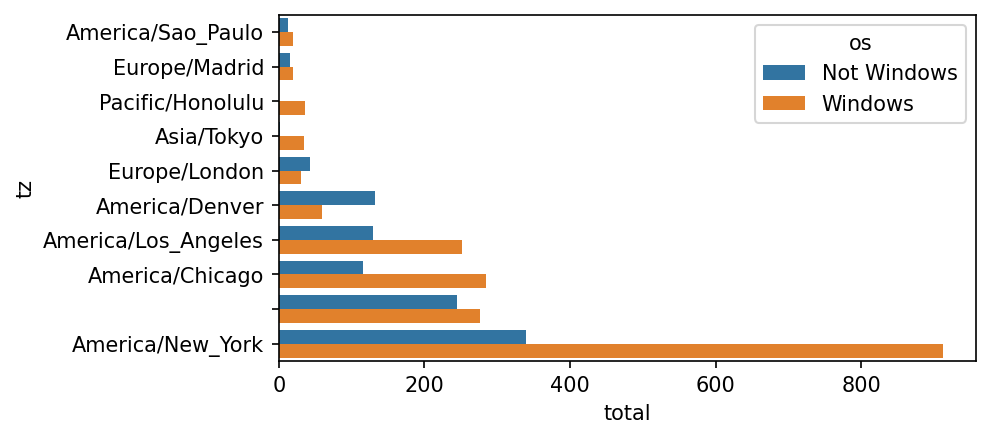

In [35]:
# count_subset now contains the 10 most common timezones in increasing order
# stack() -> stack the columns above each other into rows
# the product is a series
count_subset = count_subset.stack()

# give the series column a name
count_subset.name = "total"

# reset the index: since count_subset has hierarchical index, a dataframe is created, with the index in newly created columns
count_subset = count_subset.reset_index()

sns.barplot(x="total", y="tz", hue="os", data=count_subset)

In [36]:
count_subset.head()

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0


<Axes: xlabel='normed_total', ylabel='tz'>

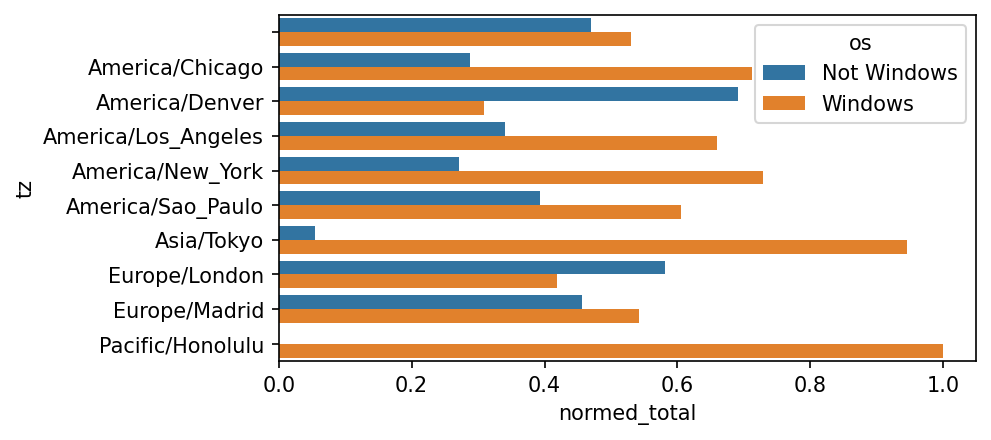

In [38]:
# normalize to a sum of 1 per group
def norm_total(group):
    """Calculates the relative frequency of each entry in the group compared to the group only"""
    group["normed_total"] = group["total"] / group["total"].sum()
    return group

# remember count_subset contains a timezone and os columns, and the number of entries of this combination
# we group by timezone so each group contains one entry per os
# then apply the norm_total function
# - remember that apply applies the function and tries to stack the result on top of each other
# results then contains a series with the relative frequency of each os in each time zone
results = count_subset.groupby("tz").apply(norm_total, include_groups=False)
sns.barplot(x="normed_total", y="tz", hue="os", data=results)

In [39]:
# compute normalized sum more efficiently
# same result as above
g = count_subset.groupby("tz")
results2 = count_subset["total"] / g["total"].transform("sum")
results2

0     0.393939
1     0.606061
2     0.457143
3     0.542857
4     0.000000
5     1.000000
6     0.054054
7     0.945946
8     0.581081
9     0.418919
10    0.691099
11    0.308901
12    0.340314
13    0.659686
14    0.287500
15    0.712500
16    0.470250
17    0.529750
18    0.270983
19    0.729017
Name: total, dtype: float64

# 13.1 MovieLens 1M Dataset

This dataset contains 1 million movie ratings from 6000 users on 4000 movies. Data is split across three tables into ratings, user information and movie information.

In [40]:
unames = ["user_id", "gender", "age", "occupation", "zip"]
users = pd.read_table("datasets/movielens/users.dat", sep="::",
                      header=None, names=unames, engine="python")

rnames = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_table("datasets/movielens/ratings.dat", sep="::",
                        header=None, names=rnames, engine="python")

mnames = ["movie_id", "title", "genres"]
movies = pd.read_table("datasets/movielens/movies.dat", sep="::",
                       header=None, names=mnames, engine="python")

In [41]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip         6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [43]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [44]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [45]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [46]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [47]:
# merge data, pandas infers the key to merge based on overlapping names
data = pd.merge(pd.merge(ratings, users), movies)
data

,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,M,25,6,11106,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,M,25,6,11106,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,956704746,M,25,6,11106,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,956715648,M,25,6,11106,Sophie's Choice (1982),Drama


In [48]:
data.iloc[0]

user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object

In [49]:
# compute mean movie ratings for each film by gender
# mean is default method
mean_ratings = data.pivot_table("rating", index="title", columns="gender")
mean_ratings.head()

gender,F,M
title,,
"$1,000,000 Duck (1971)",3.375000,2.761905
'Night Mother (1986),3.388889,3.352941
'Til There Was You (1997),2.675676,2.733333
"'burbs, The (1989)",2.793478,2.962085
...And Justice for All (1979),3.828571,3.689024


In [50]:
# select movies with more than 250 ratings
ratings_by_title = data.groupby("title").size()
ratings_by_title.head()

title
$1,000,000 Duck (1971)            37
'Night Mother (1986)              70
'Til There Was You (1997)         52
'burbs, The (1989)               303
...And Justice for All (1979)    199
dtype: int64

In [51]:
active_titles = ratings_by_title.index[ratings_by_title >= 250]
active_titles

Index([''burbs, The (1989)', '10 Things I Hate About You (1999)',
       '101 Dalmatians (1961)', '101 Dalmatians (1996)', '12 Angry Men (1957)',
       '13th Warrior, The (1999)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '2010 (1984)',
       ...
       'X-Men (2000)', 'Year of Living Dangerously (1982)',
       'Yellow Submarine (1968)', 'You've Got Mail (1998)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Sherlock Holmes (1985)',
       'Zero Effect (1998)', 'eXistenZ (1999)'],
      dtype='object', name='title', length=1216)

In [52]:
# since mean ratings uses the titles as index, we can select the titles now
mean_ratings = mean_ratings.loc[active_titles]

In [53]:
# we can find top-rated movies by female raters:
# by default, the output is sorted in an ascending fashion
top_female_ratings = mean_ratings.sort_values("F", ascending=False)
top_female_ratings.head()

gender,F,M
title,,
"Close Shave, A (1995)",4.644444,4.473795
"Wrong Trousers, The (1993)",4.588235,4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.572650,4.464589
Wallace & Gromit: The Best of Aardman Animation (1996),4.563107,4.385075
Schindler's List (1993),4.562602,4.491415


## Measuring Rating Disagreement

Find movies with the highest disagreement between male and female watchers.

In [54]:
mean_ratings["Diff"] = mean_ratings["M"] - mean_ratings["F"]
highest_diff = mean_ratings.sort_values("Diff")
highest_diff.head()

gender,F,M,Diff
title,,,
Dirty Dancing (1987),3.790378,2.959596,-0.830782
Jumpin' Jack Flash (1986),3.254717,2.578358,-0.676359
Grease (1978),3.975265,3.367041,-0.608224
Little Women (1994),3.870588,3.321739,-0.548849
Steel Magnolias (1989),3.901734,3.365957,-0.535777


In [55]:
# get movies preferred by men
highest_diff[::-1].head()

gender,F,M,Diff
title,,,
"Good, The Bad and The Ugly, The (1966)",3.494949,4.221300,0.726351
"Kentucky Fried Movie, The (1977)",2.878788,3.555147,0.676359
Dumb & Dumber (1994),2.697987,3.336595,0.638608
"Longest Day, The (1962)",3.411765,4.031447,0.619682
"Cable Guy, The (1996)",2.250000,2.863787,0.613787


In [56]:
# we can compute the highest disagreement using the standard deviation
by_title = data.groupby("title")["rating"].std()

# again filter active titles
by_title = by_title.loc[active_titles]
by_title.sort_values(ascending=False)

title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
                                           ...   
Wrong Trousers, The (1993)               0.708666
Shawshank Redemption, The (1994)         0.700443
Great Escape, The (1963)                 0.692585
Rear Window (1954)                       0.688946
Close Shave, A (1995)                    0.667143
Name: rating, Length: 1216, dtype: float64

In [57]:
# updates genres from genre1|genre2 to separate listing

# first, we split the genres into a list of strings (pop returns the column and deletes it)
movies["genre"] = movies.pop("genres").str.split("|")

# explode turns a list like into a row
movies_exploded = movies.explode("genre")
movies_exploded[:10]

,movie_id,title,genre
0,1,Toy Story (1995),Animation
0,1,Toy Story (1995),Children's
0,1,Toy Story (1995),Comedy
1,2,Jumanji (1995),Adventure
1,2,Jumanji (1995),Children's
1,2,Jumanji (1995),Fantasy
2,3,Grumpier Old Men (1995),Comedy
2,3,Grumpier Old Men (1995),Romance
3,4,Waiting to Exhale (1995),Comedy
3,4,Waiting to Exhale (1995),Drama


In [58]:
# merge back
ratings_with_genre = pd.merge(pd.merge(movies_exploded, ratings), users)
ratings_with_genre.iloc[0]

movie_id                     1
title         Toy Story (1995)
genre                Animation
user_id                      1
rating                       5
timestamp            978824268
gender                       F
age                          1
occupation                  10
zip                      48067
Name: 0, dtype: object

In [59]:
# group by genre
# unstack pivots a multiindex series into a dataframe with the index being turned into columns
genre_ratings = ratings_with_genre.groupby(["genre", "age"])["rating"].mean().unstack("age")
genre_ratings

age,1,18,25,35,45,50,56
genre,,,,,,,
Action,3.506385,3.447097,3.453358,3.538107,3.528543,3.611333,3.610709
Adventure,3.449975,3.408525,3.443163,3.515291,3.528963,3.628163,3.649064
Animation,3.476113,3.624014,3.701228,3.740545,3.734856,3.780020,3.756233
Children's,3.241642,3.294257,3.426873,3.518423,3.527593,3.556555,3.621822
Comedy,3.497491,3.460417,3.490385,3.561984,3.591789,3.646868,3.650949
Crime,3.710170,3.668054,3.680321,3.733736,3.750661,3.810688,3.832549
Documentary,3.730769,3.865865,3.946690,3.953747,3.966521,3.908108,3.961538
Drama,3.794735,3.721930,3.726428,3.782512,3.784356,3.878415,3.933465
Fantasy,3.317647,3.353778,3.452484,3.482301,3.532468,3.581570,3.532700


# 13.3 US Baby Names 1880 - 2010

In [175]:
!head -n 10 datasets/babynames/yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


In [60]:
names1880 = pd.read_csv("datasets/babynames/yob1880.txt", names=["name", "sex", "births"])
names1880.head()

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746


In [61]:
names1880.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2000 non-null   object
 1   sex     2000 non-null   object
 2   births  2000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 47.0+ KB


In [62]:
# births per year per sex
names1880.groupby("sex")["births"].sum()

sex
F     90993
M    110493
Name: births, dtype: int64

In [63]:
pieces = []
for year in range(1880, 2011):
    year_df = pd.read_csv(f"datasets/babynames/yob{year}.txt", names=["name", "sex", "births"])
    year_df["year"] = year
    pieces.append(year_df)

names = pd.concat(pieces, ignore_index=True)
names.head()

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [64]:
# get total births by sex and year using groupby
# again unstack pivots the lowest level of the hierarchical index (rows) to columns
# in this case, "sex" is the lowest level index
names.groupby(["year", "sex"])["births"].sum().unstack()

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445
...,...,...
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310


<Axes: title={'center': 'Total births by sex and year'}, xlabel='year'>

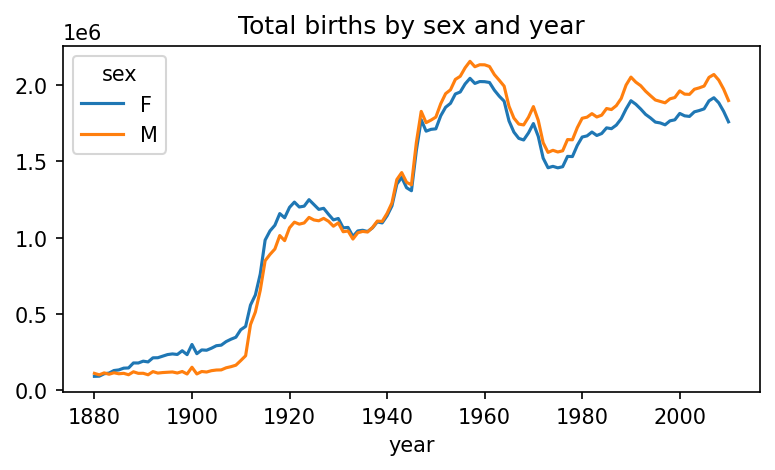

In [65]:
# and using pivot_table
births_per_year = names.pivot_table("births", index="year", columns="sex", aggfunc="sum")
births_per_year.plot(title="Total births by sex and year")

In [66]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


In [67]:
def prop(group):
    """Calculate the relative frequency of each name relative to the total number of births"""
    group["prop"] = group["births"] / group["births"].sum()
    return group

# calculate relative frequency of each name per year and sex
names = names.groupby(["year", "sex"]).apply(prop, include_groups=False).reset_index().drop(columns="level_2")

In [68]:
# sanity check to see whether the prop column sums up to 1 within each group
names.groupby(["year", "sex"])["prop"].sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

In [69]:
# top 1000 names for each sex/year combination
def get_top_1000(group):
    """Returns the 1000 most frequent names for each sex/year combination"""
    return group.sort_values("births", ascending=False)[:1000]

grouped = names.groupby(["year", "sex"])

top1000 = grouped.apply(get_top_1000, include_groups=False).reset_index(level=[0, 1])
top1000

,year,sex,name,births,prop
0,1880,F,Mary,7065,0.077643
1,1880,F,Anna,2604,0.028618
2,1880,F,Emma,2003,0.022013
3,1880,F,Elizabeth,1939,0.021309
4,1880,F,Minnie,1746,0.019188
...,...,...,...,...,...
1677639,2010,M,Camilo,194,0.000102
1677640,2010,M,Destin,194,0.000102
1677641,2010,M,Jaquan,194,0.000102
1677642,2010,M,Jaydan,194,0.000102


## Analyzing Naming Trends

In [71]:
boys = top1000[top1000["sex"] == "M"]
girls = top1000[top1000["sex"] == "F"]

In [72]:
total_births = top1000.pivot_table("births", index="year", columns="name", aggfunc="sum")

In [73]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 1880 to 2010
Columns: 6862 entries, Aaden to Zuri
dtypes: float64(6862)
memory usage: 6.9 MB


array([<Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>], dtype=object)

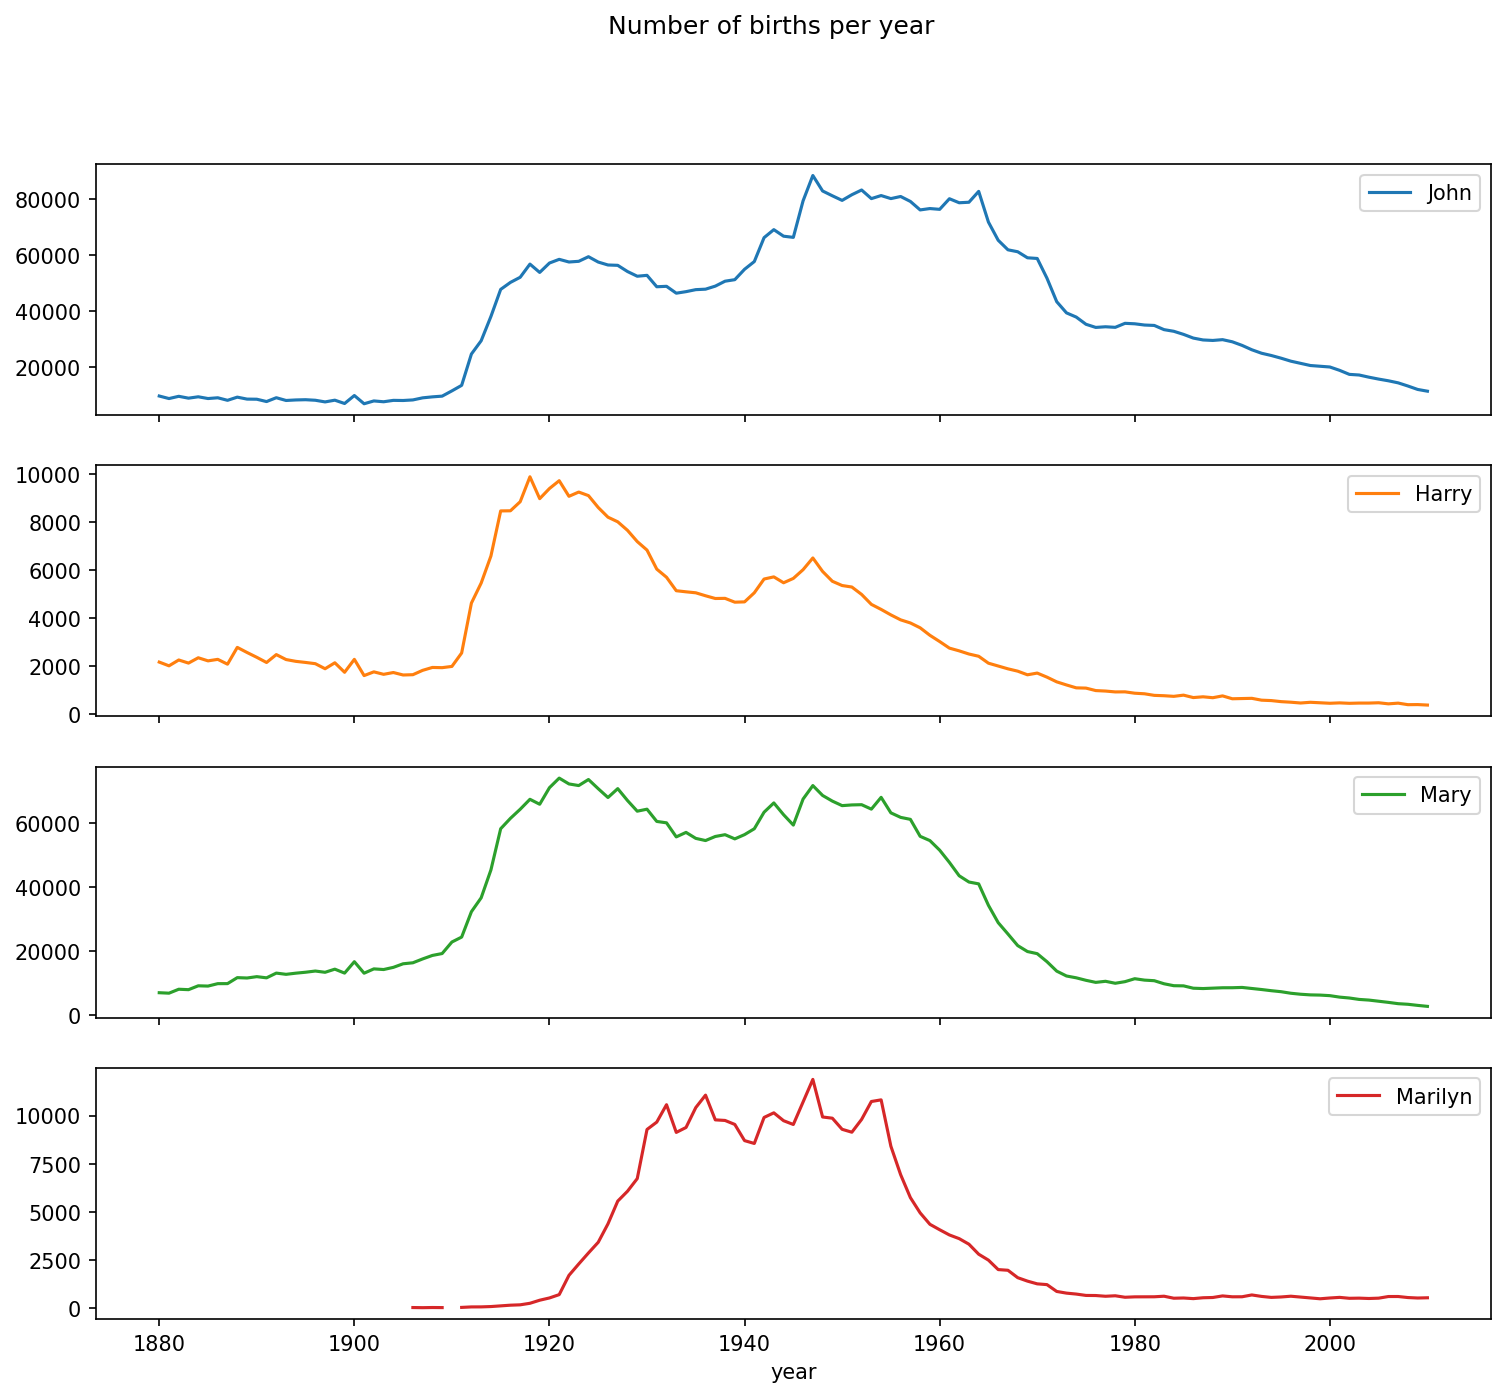

In [74]:
subset = total_births[["John", "Harry", "Mary", "Marilyn"]]
subset.plot(subplots=True, figsize=(12, 10), title="Number of births per year")

In [75]:
top1000.head()

,year,sex,name,births,prop
0,1880,F,Mary,7065,0.077643
1,1880,F,Anna,2604,0.028618
2,1880,F,Emma,2003,0.022013
3,1880,F,Elizabeth,1939,0.021309
4,1880,F,Minnie,1746,0.019188


<Axes: title={'center': 'Sum of table1000.prop by year and sex'}, xlabel='year'>

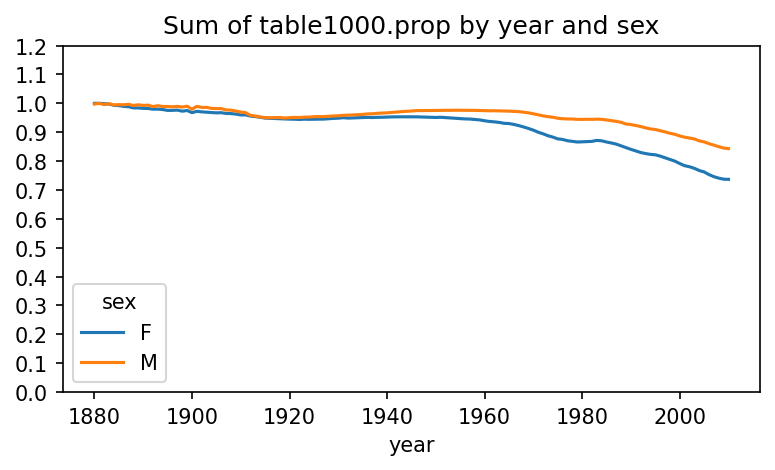

In [76]:
# measuring the increase in naming diversity
table = top1000.pivot_table("prop", index="year", columns="sex", aggfunc="sum")
table.plot(title="Sum of table1000.prop by year and sex", yticks=np.linspace(0, 1.2, 13))

In [77]:
# now look at number of distinct names taken in order of popularity from highest to lowest
df = boys[boys["year"] == 2010]
df

,year,sex,name,births,prop
1676644,2010,M,Jacob,21875,0.011523
1676645,2010,M,Ethan,17866,0.009411
1676646,2010,M,Michael,17133,0.009025
1676647,2010,M,Jayden,17030,0.008971
1676648,2010,M,William,16870,0.008887
...,...,...,...,...,...
1677639,2010,M,Camilo,194,0.000102
1677640,2010,M,Destin,194,0.000102
1677641,2010,M,Jaquan,194,0.000102
1677642,2010,M,Jaydan,194,0.000102


In [78]:
# sort prop in descending order
prop_cumsum = df["prop"].sort_values(ascending=False).cumsum()
prop_cumsum[:10]

1676644    0.011523
1676645    0.020934
1676646    0.029959
1676647    0.038930
1676648    0.047817
1676649    0.056579
1676650    0.065155
1676651    0.073414
1676652    0.081528
1676653    0.089621
Name: prop, dtype: float64

In [79]:
# how many names does it take to reach 50 % of all births
# do not forget that arrays are 0-indexed: the actual value is 1 larger
prop_cumsum.searchsorted(0.5)

np.int64(116)

In [80]:
df

,year,sex,name,births,prop
1676644,2010,M,Jacob,21875,0.011523
1676645,2010,M,Ethan,17866,0.009411
1676646,2010,M,Michael,17133,0.009025
1676647,2010,M,Jayden,17030,0.008971
1676648,2010,M,William,16870,0.008887
...,...,...,...,...,...
1677639,2010,M,Camilo,194,0.000102
1677640,2010,M,Destin,194,0.000102
1677641,2010,M,Jaquan,194,0.000102
1677642,2010,M,Jaydan,194,0.000102


In [81]:
# now let's check for 1900
prop_cumsum1900 = boys[boys["year"] == 1900]
prop_cumsum1900["prop"].sort_values(ascending=False).cumsum().searchsorted(0.5) + 1

np.int64(25)

In [82]:
def get_quantile_count(group, q=0.5):
    """Returns the number of names it needs to reach 50 % of all births in a given group"""
    group = group.sort_values("prop", ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1

diversity = top1000.groupby(["year", "sex"]).apply(get_quantile_count, include_groups=False)
diversity = diversity.unstack()
diversity

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16
...,...,...
2006,209,99
2007,223,103
2008,234,109


<Axes: title={'center': 'Number of popular names in top 50 %'}, xlabel='year'>

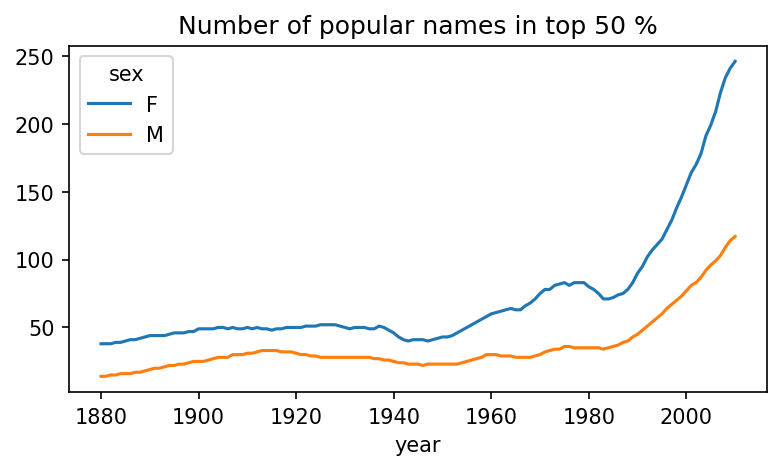

In [83]:
diversity.plot(title="Number of popular names in top 50 %")

In [84]:
names.head()

,year,sex,name,births,prop
0,1880,F,Mary,7065,0.077643
1,1880,F,Anna,2604,0.028618
2,1880,F,Emma,2003,0.022013
3,1880,F,Elizabeth,1939,0.021309
4,1880,F,Minnie,1746,0.019188


In [85]:
def get_last_letter(x):
    """Returns the last letter of a string"""
    return x[-1]

last_letters = names["name"].map(get_last_letter)
last_letters.name = "last_letter"
last_letters.head()

0    y
1    a
2    a
3    h
4    e
Name: last_letter, dtype: object

In [86]:
table = names.pivot_table("births", index=last_letters, columns=["sex", "year"], aggfunc="sum")

# select a few representative years
subtable = table.reindex(columns=[1910, 1960, 2010], level="year")
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [87]:
letter_prop = subtable / subtable.sum()
letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
f                 NaN  0.000010  0.000055  0.000783  0.004325  0.001188
g            0.000144  0.000157  0.000374  0.002250  0.009488  0.001404
h            0.051529  0.036224  0.075852  0.045562  0.037907  0.051670
i            0.001526  0.039965  0.031734  0.000844  0.000603  0.022628
j                 NaN       NaN  0.000090       NaN       NaN  0.000769
k            0.000121  0.000156  0.000356  0.036581  0.049384  0.018541
l            0.043189  0.033867  0.026356  0.065016  0.104904  0.070367
m            0.001201  0.008613  0.002588  0.058044  0.033827  0.024657
n            0.079240  0.130687  0.140210  0.143415  0.152522  0.362771
o            0.001660  0.002439  0.001243  0.017065  0.012829  0.042681
p            0.000018  0.000023  0.000020  0.003172  0.005675  0.001269
q                 NaN       NaN  0.000030       NaN       NaN  0.000180
r            0.013390  0.006764  0.018025  0.064481  0.031034  0.087477
s            0.039042  0.012764  0.013332  0.130815  0.102730  0.065145
t            0.027438  0.015201  0.007830  0.072879  0.065655  0.022861
u            0.000684  0.000574  0.000417  0.000124  0.000057  0.001221
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

<Axes: title={'center': 'Female'}, xlabel='last_letter'>

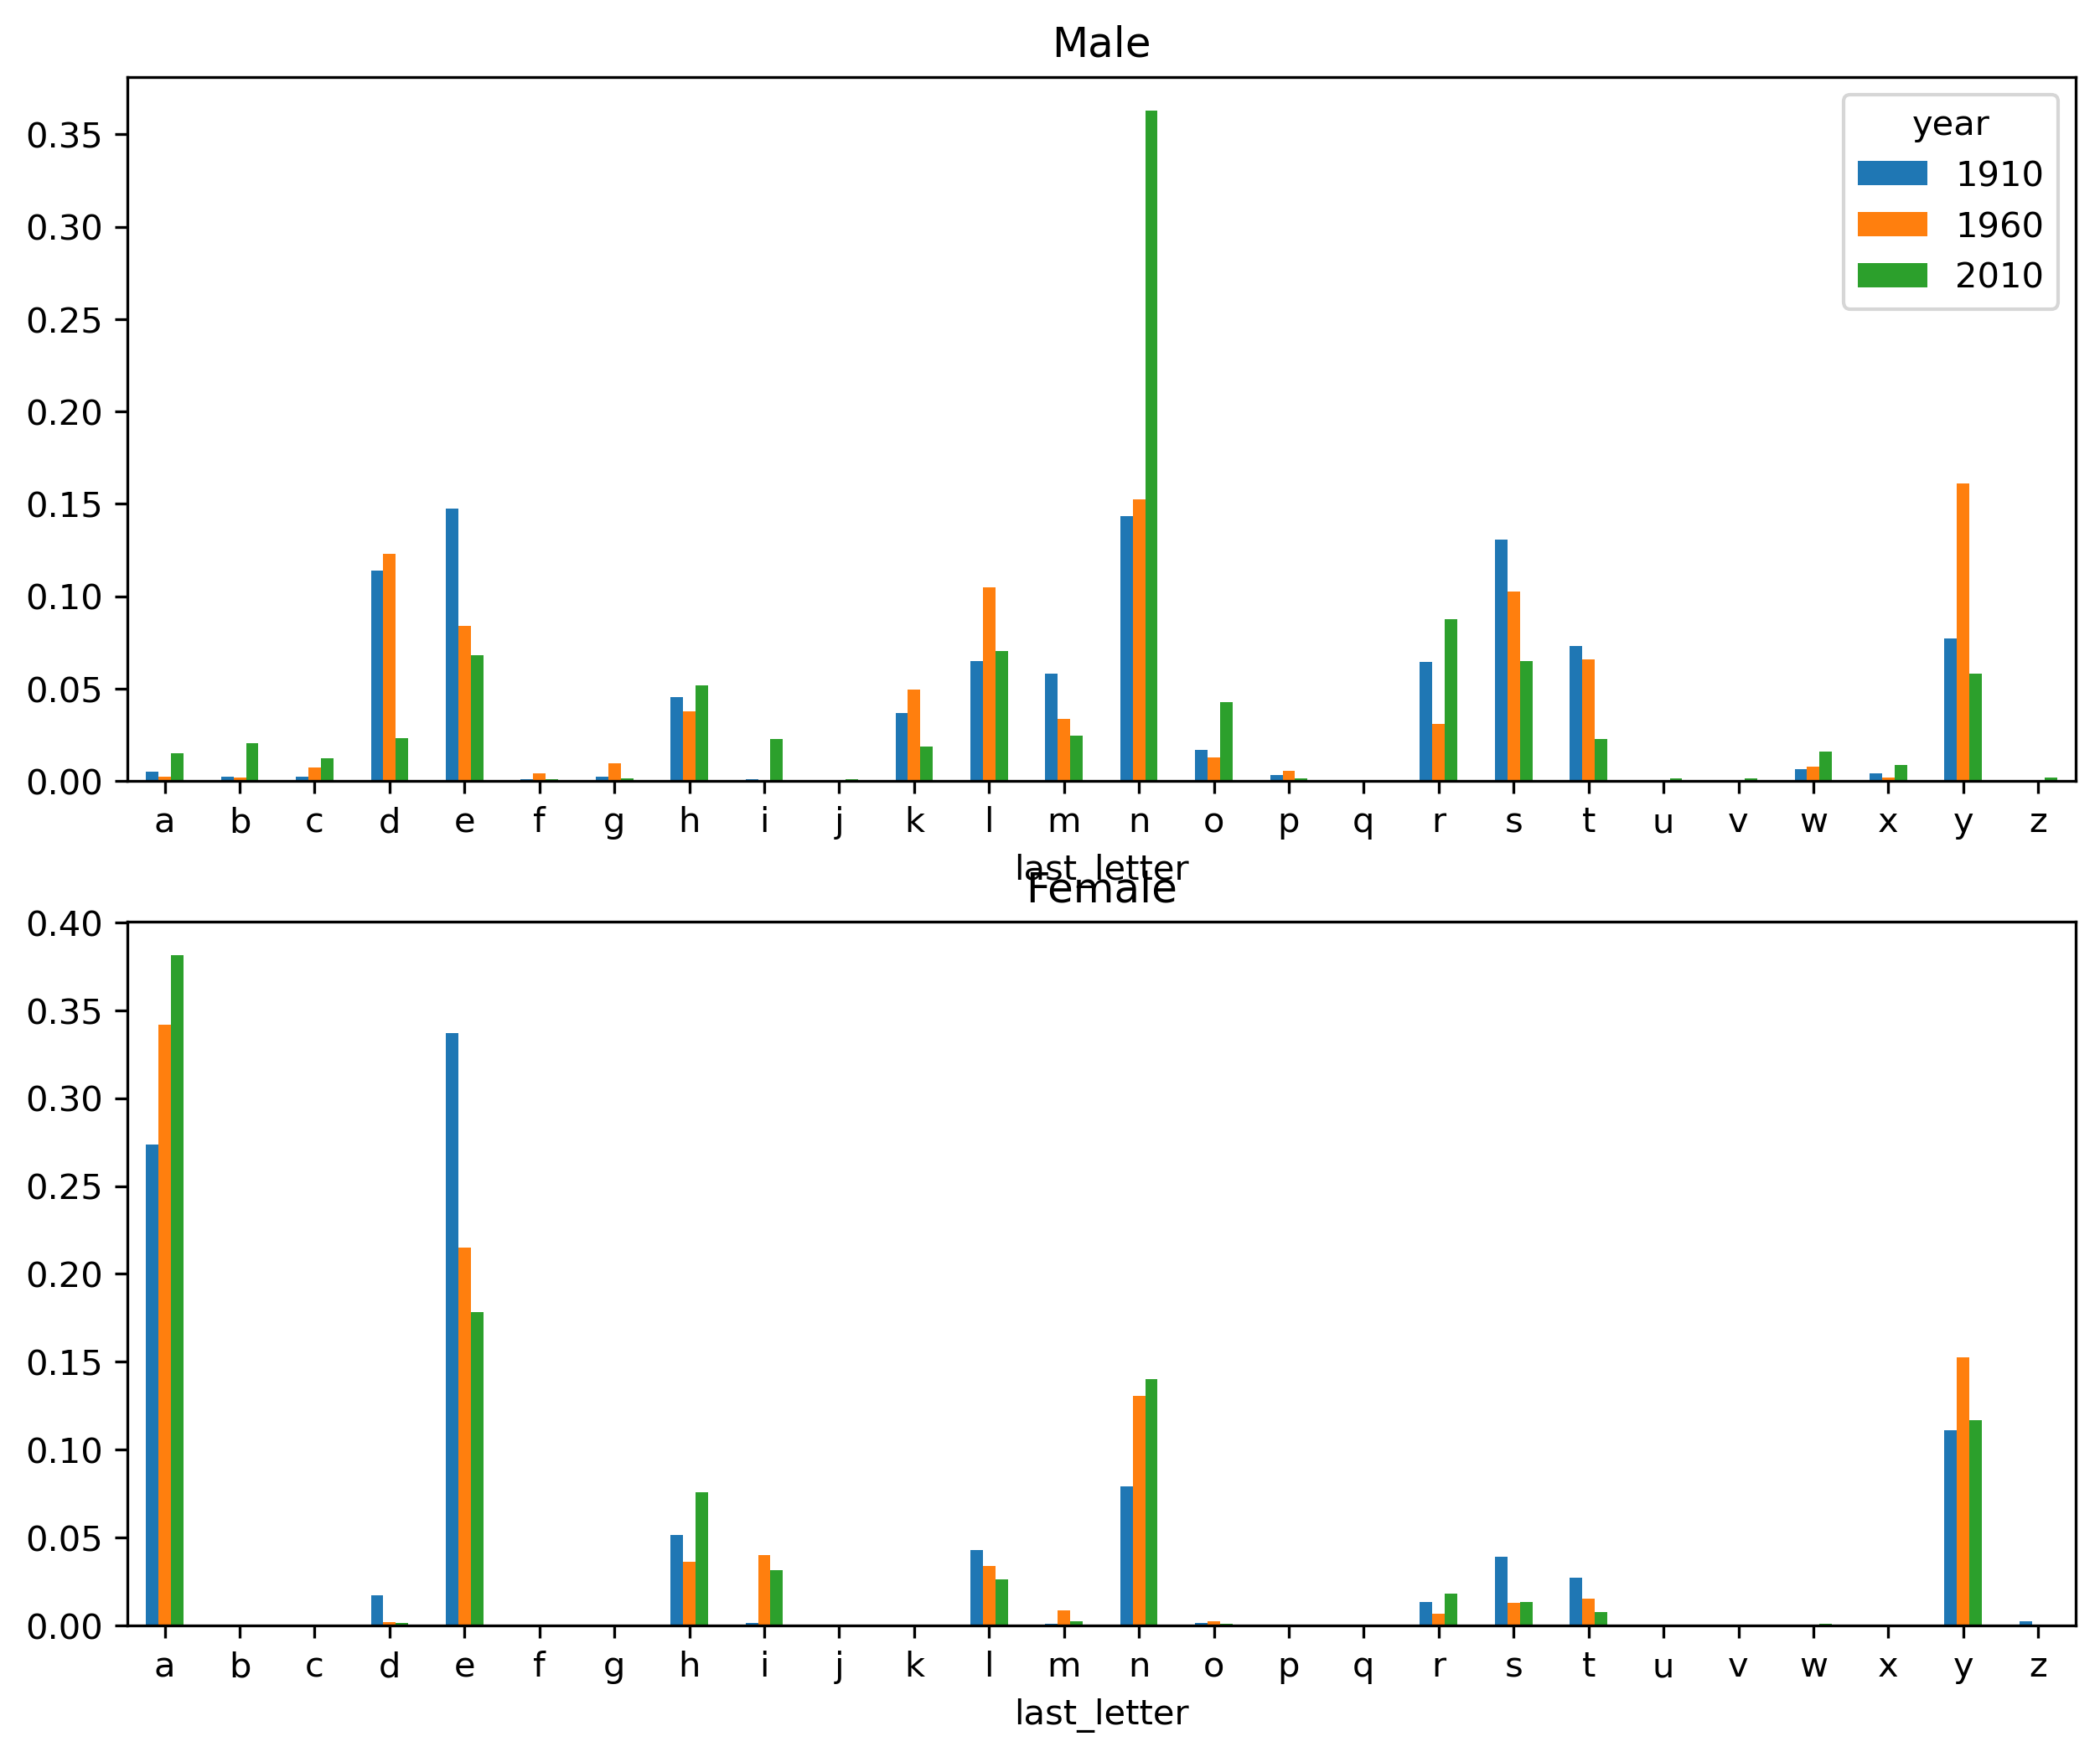

In [339]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop["M"].plot(kind="bar", rot=0, ax=axes[0], title="Male")
letter_prop["F"].plot(kind="bar", rot=0, ax=axes[1], title="Female", legend=False)

In [340]:
letter_prop = table / table.sum()
dny_ts = letter_prop.loc[["d", "n", "y"], "M"].T
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


<Axes: xlabel='year'>

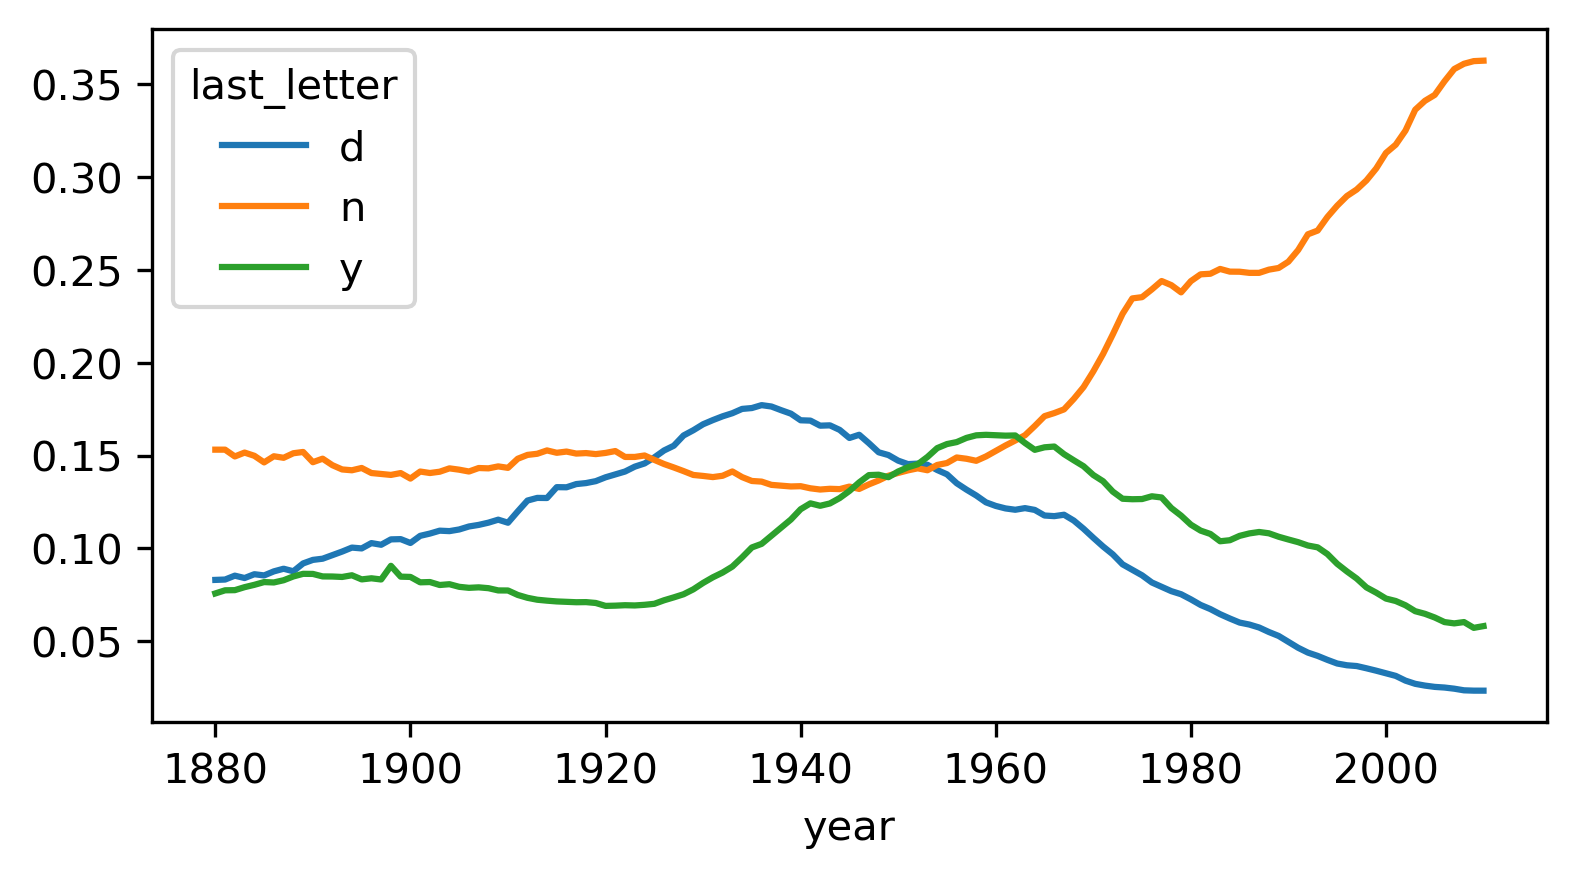

In [342]:
dny_ts.plot()

In [343]:
all_names = pd.Series(top1000["name"].unique())
lesley_like = all_names[all_names.str.contains("Lesl")]
lesley_like

654     Leslie
2307    Lesley
4257    Leslee
4725     Lesli
6096     Lesly
dtype: object

In [344]:
# choose all rows that have a lesley_like name
filtered = top1000[top1000["name"].isin(lesley_like)]

# group the data by name and calculate the total births of each name
filtered.groupby("name")["births"].sum()

name
Leslee       993
Lesley     35009
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

In [348]:
# create a pivot table that contains the total number of births for each year and split across sex
table = filtered.pivot_table("births", index="year", columns="sex", aggfunc="sum")

# divide each element in the dataframe with the sum of values per column
# so we calculate the proportion of male and female persons named lesley like per year
table = table.div(table.sum(axis="columns"), axis="index")
table.head()

sex,F,M
year,,
1880,0.091954,0.908046
1881,0.106796,0.893204
1882,0.065693,0.934307
1883,0.053030,0.946970
1884,0.107143,0.892857


<Axes: xlabel='year'>

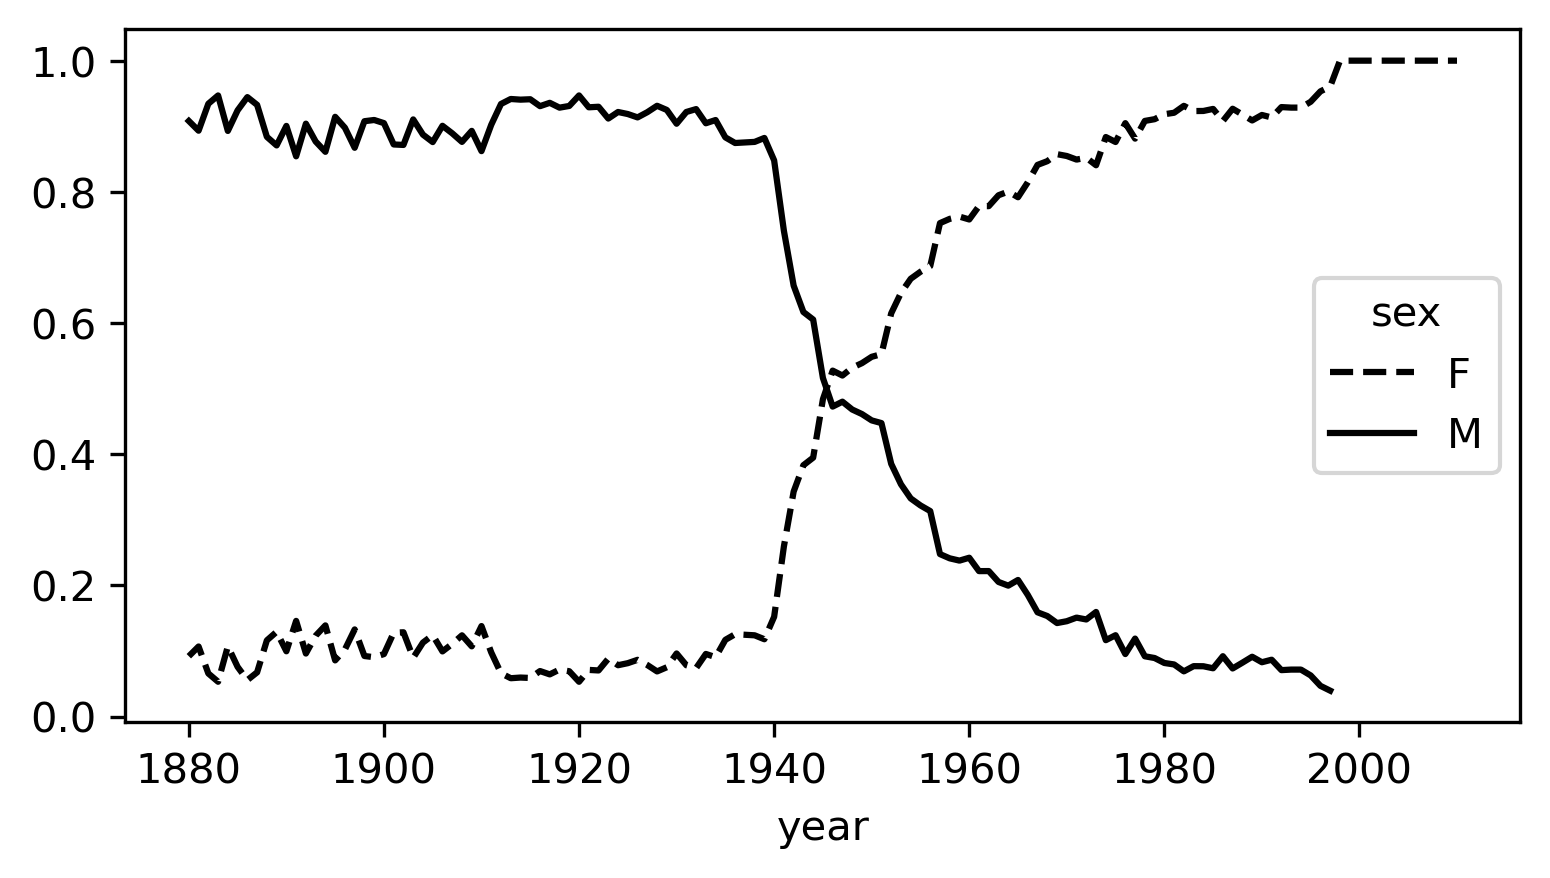

In [349]:
table.plot(style={"M": "k-", "F": "k--"})

# 13.4 USDA Food Database

In [89]:
import json

db = json.load(open("datasets/usda_food/database.json"))
len(db)

6636

In [90]:
type(db), type(db[0])

(list, dict)

In [97]:
db[0]

{'id': 1008,
 'description': 'Cheese, caraway',
 'tags': [],
 'manufacturer': '',
 'group': 'Dairy and Egg Products',
 'portions': [{'amount': 1, 'unit': 'oz', 'grams': 28.35}],
 'nutrients': [{'value': 25.18,
   'units': 'g',
   'description': 'Protein',
   'group': 'Composition'},
  {'value': 29.2,
   'units': 'g',
   'description': 'Total lipid (fat)',
   'group': 'Composition'},
  {'value': 3.06,
   'units': 'g',
   'description': 'Carbohydrate, by difference',
   'group': 'Composition'},
  {'value': 3.28, 'units': 'g', 'description': 'Ash', 'group': 'Other'},
  {'value': 376.0,
   'units': 'kcal',
   'description': 'Energy',
   'group': 'Energy'},
  {'value': 39.28,
   'units': 'g',
   'description': 'Water',
   'group': 'Composition'},
  {'value': 1573.0, 'units': 'kJ', 'description': 'Energy', 'group': 'Energy'},
  {'value': 0.0,
   'units': 'g',
   'description': 'Fiber, total dietary',
   'group': 'Composition'},
  {'value': 673.0,
   'units': 'mg',
   'description': 'Calcium,

In [91]:
nutrients = pd.DataFrame(db[0]["nutrients"])
nutrients.head()

,value,units,description,group
0,25.18,g,Protein,Composition
1,29.20,g,Total lipid (fat),Composition
2,3.06,g,"Carbohydrate, by difference",Composition
3,3.28,g,Ash,Other
4,376.00,kcal,Energy,Energy


In [92]:
# we can directly convert a list of dictionaries to a dataframe
info_keys = ["description", "group", "id", "manufacturer"]
info = pd.DataFrame(db, columns=info_keys)
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


In [93]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   6636 non-null   object
 1   group         6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [94]:
info["group"].value_counts()

group
Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Legumes and Legume Products          365
Fast Foods                           365
Lamb, Veal, and Game Products        345
Sweets                               341
Fruits and Fruit Juices              328
Pork Products                        328
Beverages                            278
Soups, Sauces, and Gravies           275
Finfish and Shellfish Products       255
Baby Foods                           209
Cereal Grains and Pasta              183
Ethnic Foods                         165
Snacks                               162
Nut and Seed Products                128
Poultry Products                     116
Sausages and Luncheon Meats          111
Dairy and Egg Products               107
Fats and Oils                         97
Meals, Entrees, and Sidedishes        57
Restaurant Foods                      51
Spices and

In [95]:
nutrients = []
for rec in db:
    fnuts = pd.DataFrame(rec["nutrients"])
    fnuts["id"] = rec["id"]
    nutrients.append(fnuts)

nutrients = pd.concat(nutrients, ignore_index=True)

In [96]:
nutrients.head()

,value,units,description,group,id
0,25.18,g,Protein,Composition,1008
1,29.20,g,Total lipid (fat),Composition,1008
2,3.06,g,"Carbohydrate, by difference",Composition,1008
3,3.28,g,Ash,Other,1008
4,376.00,kcal,Energy,Energy,1008


In [98]:
print(nutrients.duplicated().sum())

# drop any duplicates
nutrients = nutrients.drop_duplicates()

14179


In [115]:
col_mapping = {"description": "food", "group": "fgroup"}

info = info.rename(columns=col_mapping, copy=False)
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   food          6636 non-null   object
 1   fgroup        6636 non-null   object
 2   id            6636 non-null   int64 
 3   manufacturer  5195 non-null   object
dtypes: int64(1), object(3)
memory usage: 207.5+ KB


In [116]:
col_mapping = {"description": "nutrient", "group": "nutgroup"}
nutrients = nutrients.rename(columns=col_mapping, copy=False)
nutrients

,value,units,nutrient,nutgroup,id
0,25.180,g,Protein,Composition,1008
1,29.200,g,Total lipid (fat),Composition,1008
2,3.060,g,"Carbohydrate, by difference",Composition,1008
3,3.280,g,Ash,Other,1008
4,376.000,kcal,Energy,Energy,1008
...,...,...,...,...,...
389350,0.000,mcg,"Vitamin B-12, added",Vitamins,43546
389351,0.000,mg,Cholesterol,Other,43546
389352,0.072,g,"Fatty acids, total saturated",Other,43546
389353,0.028,g,"Fatty acids, total monounsaturated",Other,43546


In [117]:
ndata = pd.merge(nutrients, info, on="id")
ndata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375176 entries, 0 to 375175
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   value         375176 non-null  float64
 1   units         375176 non-null  object 
 2   nutrient      375176 non-null  object 
 3   nutgroup      375176 non-null  object 
 4   id            375176 non-null  int64  
 5   food          375176 non-null  object 
 6   fgroup        375176 non-null  object 
 7   manufacturer  293054 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 22.9+ MB


In [118]:
ndata.iloc[10000]

value                                                0.104
units                                                    g
nutrient                                          Arginine
nutgroup                                       Amino Acids
id                                                    3197
food            Babyfood, cereal, with egg yolks, strained
fgroup                                          Baby Foods
manufacturer                                              
Name: 10000, dtype: object

<Axes: ylabel='fgroup'>

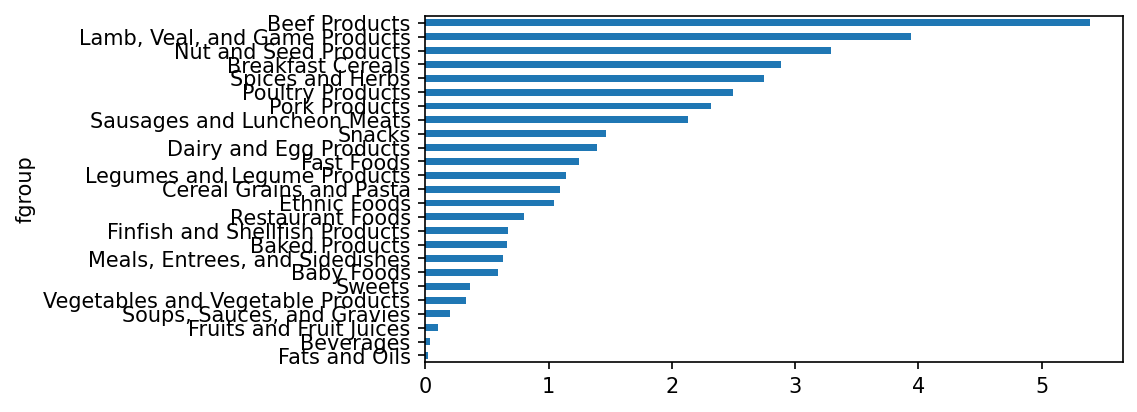

In [119]:
# plot median values per nutrient and food group
result = ndata.groupby(["nutrient", "fgroup"])["value"].quantile(0.5)
result["Zinc, Zn"].sort_values().plot(kind="barh")

<Axes: ylabel='fgroup'>

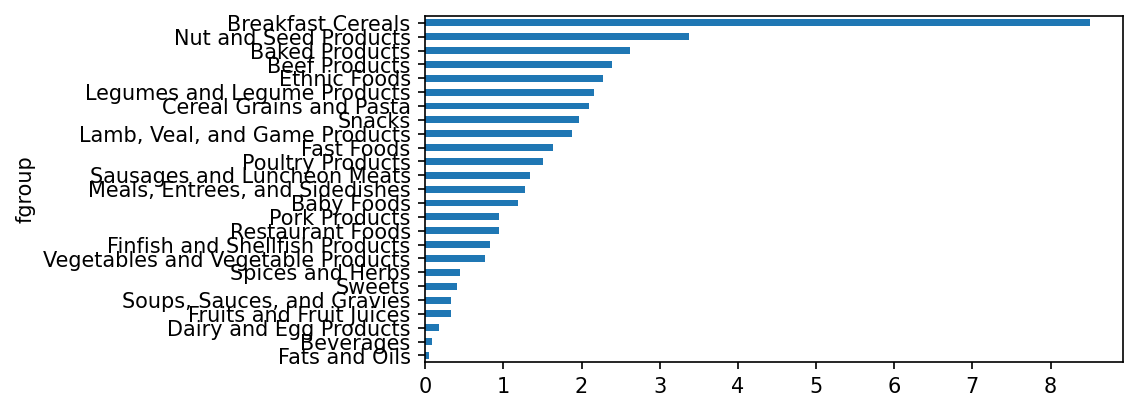

In [120]:
result["Iron, Fe"].sort_values().plot(kind="barh")

In [121]:
ndata.head()

,value,units,nutrient,nutgroup,id,food,fgroup,manufacturer
0,25.18,g,Protein,Composition,1008,"Cheese, caraway",Dairy and Egg Products,
1,29.20,g,Total lipid (fat),Composition,1008,"Cheese, caraway",Dairy and Egg Products,
2,3.06,g,"Carbohydrate, by difference",Composition,1008,"Cheese, caraway",Dairy and Egg Products,
3,3.28,g,Ash,Other,1008,"Cheese, caraway",Dairy and Egg Products,
4,376.00,kcal,Energy,Energy,1008,"Cheese, caraway",Dairy and Egg Products,


In [123]:
by_nutrient = ndata.groupby(["nutgroup", "nutrient"])

def get_maximum(x):
    """"""
    return x.loc[x.value.idxmax()]
max_foods = by_nutrient.apply(get_maximum, include_groups=False)[["value", "food"]]
max_foods["food"] = max_foods["food"].str[:50]

In [124]:
max_foods.loc["Amino Acids"]["food"]

nutrient
Alanine                           Gelatins, dry powder, unsweetened
Arginine                               Seeds, sesame flour, low-fat
Aspartic acid                                   Soy protein isolate
Cystine                Seeds, cottonseed flour, low fat (glandless)
Glutamic acid                                   Soy protein isolate
Glycine                           Gelatins, dry powder, unsweetened
Histidine                Whale, beluga, meat, dried (Alaska Native)
Hydroxyproline    KENTUCKY FRIED CHICKEN, Fried Chicken, ORIGINA...
Isoleucine        Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Leucine           Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Lysine            Seal, bearded (Oogruk), meat, dried (Alaska Na...
Methionine                    Fish, cod, Atlantic, dried and salted
Phenylalanine     Soy protein isolate, PROTEIN TECHNOLOGIES INTE...
Proline                           Gelatins, dry powder, unsweetened
Serine            Soy protein isolate, 

# 13.5 2012 Federal Election Commission Database

In [125]:
fec = pd.read_csv("datasets/fec/P00000001-ALL.csv", low_memory=False)
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [126]:
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                        50.0
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [127]:
unique_cands = fec["cand_nm"].unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [128]:
parties = {
    "Bachmann, Michelle": "Republican",
    "Cain, Herman": "Republican",
    "Gingrich, Newt": "Republican",
    "Huntsman, Jon": "Republican",
    "Johnson, Gary Earl": "Republican",
    "McCotter, Thaddeus G": "Republican",
    "Obama, Barack": "Democrat",
    "Paul, Ron": "Republican",
    "Pawlenty, Timothy": "Republican",
    "Perry, Rick": "Republican",
    "Roemer, Charles E. 'Buddy' III": "Republican",
    "Romney, Mitt": "Republican",
    "Santorum, Rick": "Republican"
}

In [129]:
fec["party"] = fec["cand_nm"].map(parties)
fec["party"].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

In [130]:
(fec["contb_receipt_amt"] > 0).value_counts()

contb_receipt_amt
True     991475
False     10256
Name: count, dtype: int64

In [131]:
# make sure only positive amounts are in the data
fec = fec[fec["contb_receipt_amt"] > 0]

In [132]:
# pick the 2 main candidates
fec_mrbo = fec[fec["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])]

## Donation Statistics by Occupation and Employer

In [133]:
fec["contbr_occupation"].value_counts()[:50]

contbr_occupation
RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
NOT EMPLOYED                                9828
SALES                                       8333
LAWYER                                      8283
MANAGER                                     8024
PRESIDENT                                   7758
STUDENT                                     7071
OWNER                                       6343
EXECUTIVE                                   5506
SELF-EMPLOYED                               5472
WRITER                                      5128
SO

In [134]:
# same profession is referred to in different terms
occ_mapping = {
   "INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
   "INFORMATION REQUESTED" : "NOT PROVIDED",
   "INFORMATION REQUESTED (BEST EFFORTS)" : "NOT PROVIDED",
   "C.E.O.": "CEO"
}

def get_occ(x):
    return occ_mapping.get(x, x)

fec["contbr_occupation"] = fec["contbr_occupation"].map(get_occ)

In [135]:
# same for employers
emp_mapping = {
   "INFORMATION REQUESTED PER BEST EFFORTS" : "NOT PROVIDED",
   "INFORMATION REQUESTED" : "NOT PROVIDED",
   "SELF" : "SELF-EMPLOYED",
   "SELF EMPLOYED" : "SELF-EMPLOYED",
}

def get_emp(x):
    return emp_mapping.get(x, x)

fec["contbr_employer"] = fec["contbr_employer"].map(get_emp)

In [136]:
fec.head()

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
0,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,250.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
1,C00410118,P20002978,"Bachmann, Michelle","HARVEY, WILLIAM",MOBILE,AL,366010290,RETIRED,RETIRED,50.0,23-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican
2,C00410118,P20002978,"Bachmann, Michelle","SMITH, LANIER",LANETT,AL,368633403,NOT PROVIDED,NOT PROVIDED,250.0,05-JUL-11,NaN,NaN,NaN,SA17A,749073,Republican
3,C00410118,P20002978,"Bachmann, Michelle","BLEVINS, DARONDA",PIGGOTT,AR,724548253,NONE,RETIRED,250.0,01-AUG-11,NaN,NaN,NaN,SA17A,749073,Republican
4,C00410118,P20002978,"Bachmann, Michelle","WARDENBURG, HAROLD",HOT SPRINGS NATION,AR,719016467,NONE,RETIRED,300.0,20-JUN-11,NaN,NaN,NaN,SA17A,736166,Republican


In [137]:
by_occupation = fec.pivot_table("contb_receipt_amt", index="contbr_occupation", columns="party", aggfunc="sum")
over_2mm = by_occupation[by_occupation.sum(axis="columns") > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
CEO,2074974.79,4211040.52
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32
MANAGER,762883.22,1444532.37


<Axes: ylabel='contbr_occupation'>

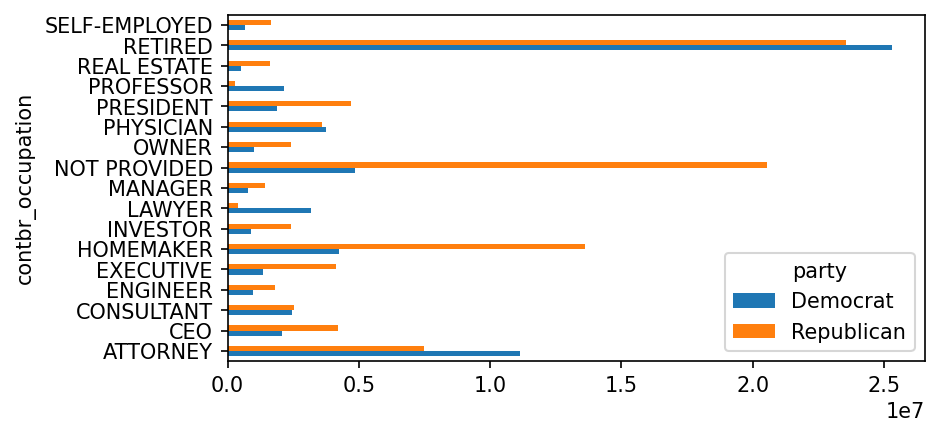

In [138]:
over_2mm.plot(kind="barh")

In [139]:
def get_top_amounts(group, key, n=5):
    total_amts = group.groupby(key)["contb_receipt_amt"].sum()
    return total_amts.nlargest(n)

# we group by the candidate name
grouped = fec_mrbo.groupby("cand_nm")

# then we apply the function get_top_amounts
# which groups again by some column and calculates the sum for that
# group of all donations
grouped.apply(get_top_amounts, "contbr_occupation", n=7, include_groups=False)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [140]:
grouped.apply(get_top_amounts, "contbr_employer", n=10, include_groups=False)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

## Bucketing Donation Amounts

In [141]:
## Bucketing Donation Amounts
bins = np.array([0, 1, 10, 100, 1000, 10000, 100_000, 1_000_000, 10_000_000])
labels = pd.cut(fec_mrbo["contb_receipt_amt"], bins)
labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [142]:
# group by candidate name and bin label
grouped = fec_mrbo.groupby(["cand_nm", labels], observed=False)
grouped.size().unstack(level=0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


In [143]:
bucket_sums = grouped["contb_receipt_amt"].sum().unstack(level=0)
normed_sums = bucket_sums.div(bucket_sums.sum(axis="columns"), axis="index")
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


<Axes: ylabel='contb_receipt_amt'>

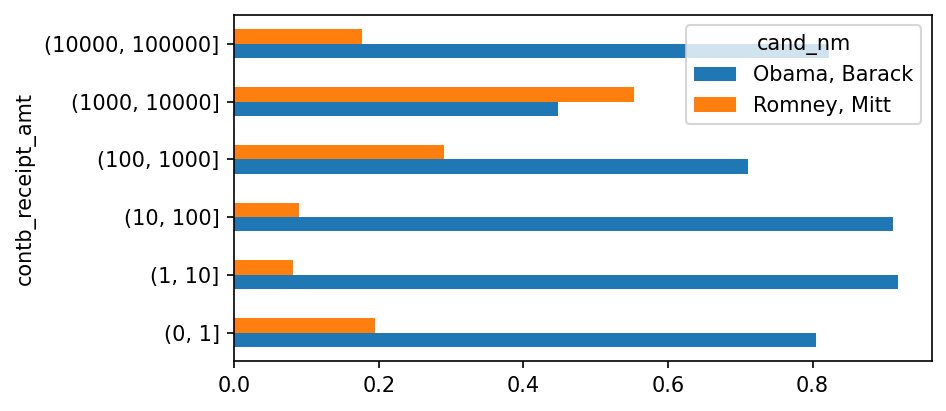

In [144]:
normed_sums[:-2].plot(kind="barh")

## Donation Statistics by State

In [145]:
# we group by candidate and state
grouped = fec_mrbo.groupby(["cand_nm", "contbr_st"])

# compute the sum of the amount and unstack the candidate
totals = grouped["contb_receipt_amt"].sum().unstack(level=0).fillna(0)

# pick states with more than 100_000 total donation amount
totals = totals[totals.sum(axis="columns") > 100_000]
totals

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [146]:
# normalize per state: get the percentage of donations for each candidate per state
percent = totals.div(totals.sum(axis="columns"), axis="index")
percent

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
